In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [3]:
import tensorflow as tf
import malaya_speech
import malaya_speech.train
from malaya_speech.train.model import fastpitch
import numpy as np






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
_pad = 'pad'
_start = 'start'
_eos = 'eos'
_punctuation = "!'(),.:;? "
_special = '-'
_letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
_rejected = '\'():;"'

MALAYA_SPEECH_SYMBOLS = (
    [_pad, _start, _eos] + list(_special) + list(_punctuation) + list(_letters)
)

In [5]:
input_ids = tf.placeholder(tf.int32, [None, None])
lens = tf.placeholder(tf.int32, [None, None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])
pitches = tf.placeholder(tf.float32, [None, None])
pitches_lengths = tf.placeholder(tf.int32, [None])

In [6]:
config = malaya_speech.config.fastspeech2_config
config = fastpitch.Config(
    vocab_size = len(MALAYA_SPEECH_SYMBOLS), **config
)
model = fastpitch.Model(config)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
r_training = model(input_ids, lens, pitches, training = False)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
speed_ratios = tf.placeholder(tf.float32, [None], name = 'speed_ratios')
pitch_ratios = tf.placeholder(tf.float32, [None], name = 'pitch_ratios')
pitch_addition = tf.placeholder(tf.float32, [None], name = 'pitch_addition')

def transform(pitch_outputs, attention_mask):
    weights = tf.cast(attention_mask, tf.int32) * tf.expand_dims(tf.range(tf.shape(pitch_outputs)[1]), 0)
    weights = tf.cast(weights, tf.float32) / tf.cast(tf.shape(pitch_outputs)[1], tf.float32)
    weights += 2.0
    return pitch_outputs * weights

r = model.inference(input_ids, speed_ratios, pitch_ratios, pitch_addition)

In [9]:
r

(<tf.Tensor 'mel_before/BiasAdd:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'add_3:0' shape=(?, ?, 80) dtype=float32>,
 <tf.Tensor 'Cast:0' shape=(?, ?) dtype=int32>,
 <tf.Tensor 'mul_1:0' shape=(?, ?) dtype=float32>)

In [10]:
decoder_output = tf.identity(r[0], name = 'decoder_output')
post_mel_outputs = tf.identity(r[1], name = 'post_mel_outputs')
pitch_outputs = tf.identity(r[3], name = 'pitch_outputs')

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
path = 'fastpitch-female-singlish'
ckpt_path = tf.train.latest_checkpoint(path)
ckpt_path

'fastpitch-female-singlish/model.ckpt-200000'

In [13]:
saver = tf.train.Saver()
saver.restore(sess, ckpt_path)

INFO:tensorflow:Restoring parameters from fastpitch-female-singlish/model.ckpt-200000


In [14]:
import re
from unidecode import unidecode
import malaya

normalizer = malaya.normalize.normalizer(date = False, time = False)
pad_to = 8

def tts_encode(string: str, add_eos: bool = True):
    r = [MALAYA_SPEECH_SYMBOLS.index(c) for c in string if c in MALAYA_SPEECH_SYMBOLS]
    if add_eos:
        r = r + [MALAYA_SPEECH_SYMBOLS.index('eos')]
    return r

def put_spacing_num(string):
    string = re.sub('[A-Za-z]+', lambda ele: ' ' + ele[0] + ' ', string)
    return re.sub(r'[ ]+', ' ', string).strip()

def convert_to_ascii(string):
    return unidecode(string)

def collapse_whitespace(string):
    return re.sub(_whitespace_re, ' ', string)

def cleaning(string, normalize = True, add_eos = False):
    sequence = []
    string = convert_to_ascii(string)
    if string[-1] in '-,':
        string = string[:-1]
    if string[-1] not in '.,?!':
        string = string + '.'
    string = string.replace('&', ' dan ')
    string = string.replace(':', ',').replace(';', ',')
    if normalize:
        t = normalizer._tokenizer(string)
        for i in range(len(t)):
            if t[i] == '-':
                t[i] = ','
        string = ' '.join(t)
        string = normalizer.normalize(string, 
                                      check_english = False, 
                                      normalize_entity = False, 
                                      normalize_text = False,
                                      normalize_url = True,
                                      normalize_email = True,
                                      normalize_year = True)
        string = string['normalize']
    else:
        string = string
    string = put_spacing_num(string)
    string = ''.join([c for c in string if c in MALAYA_SPEECH_SYMBOLS and c not in _rejected])
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = string.lower()
    ids = tts_encode(string, add_eos = add_eos)
    text_input = np.array(ids)
    num_pad = pad_to - ((len(text_input) + 2) % pad_to)
    text_input = np.pad(
        text_input, ((1, 1)), 'constant', constant_values = ((1, 2))
    )
    text_input = np.pad(
        text_input, ((0, num_pad)), 'constant', constant_values = 0
    )
    
    return string, text_input

In [15]:
import matplotlib.pyplot as plt

In [16]:
# https://umno-online.my/2020/12/28/isu-kartel-daging-haram-lagi-pihak-gesa-kerajaan-ambil-tindakan-tegas-drastik/

t, ids = cleaning('i hate chicken i but like it sometime, and kuih putu mayam')
t, ids

('i hate chicken i but like it sometime , and kuih putu mayam .',
 array([ 1, 48, 13, 47, 40, 59, 44, 13, 42, 47, 48, 42, 50, 44, 53, 13, 48,
        13, 41, 60, 59, 13, 51, 48, 50, 44, 13, 48, 59, 13, 58, 54, 52, 44,
        59, 48, 52, 44, 13,  8, 13, 40, 53, 43, 13, 50, 60, 48, 47, 13, 55,
        60, 59, 60, 13, 52, 40, 64, 40, 52, 13,  9,  2,  0]))

In [18]:
%%time

o = sess.run([decoder_output, post_mel_outputs, pitch_outputs], feed_dict = {input_ids: [ids], 
                             speed_ratios: [1.0],
                             pitch_ratios: [1.5],
                             pitch_addition: [-1.0]})

CPU times: user 1.41 s, sys: 6.16 ms, total: 1.41 s
Wall time: 704 ms


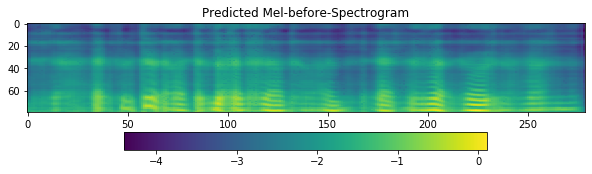

In [19]:
mel_outputs_ = np.reshape(o[1], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

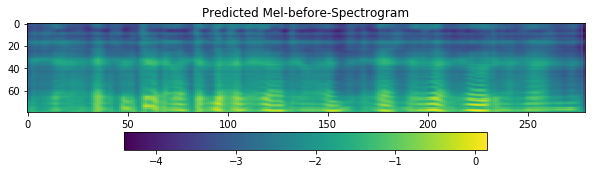

In [20]:
mel_outputs_ = np.reshape(o[0], [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [21]:
import pickle

with open('a.pkl', 'wb') as fopen:
    pickle.dump([np.reshape(o[0], [-1, 80]), np.reshape(o[1], [-1, 80])], fopen)

In [22]:
saver = tf.train.Saver()
saver.save(sess, 'fastpitch-female-singlish-output/model.ckpt')

'fastpitch-female-singlish-output/model.ckpt'

In [23]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'gather' in n.op.lower()
        or 'Placeholder' in n.name
        or 'ratios' in n.name
        or 'pitch_addition' in n.name 
        or 'pitch_outputs' in n.name
        or 'post_mel_outputs' in n.name
        or 'decoder_output' in n.name
        or 'alignment_histories' in n.name)
        and 'adam' not in n.name
        and 'global_step' not in n.name
        and 'Assign' not in n.name
        and 'ReadVariableOp' not in n.name
        and 'Gather' not in n.name
        and 'IsVariableInitialized' not in n.name
    ]
)
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Placeholder_2',
 'Placeholder_3',
 'Placeholder_4',
 'Placeholder_5',
 'weight',
 'model/embeddings/position_embeddings/Placeholder',
 'model/decoder/position_embeddings/Placeholder',
 'speed_ratios',
 'pitch_ratios',
 'pitch_addition',
 'decoder_output',
 'post_mel_outputs',
 'pitch_outputs']

In [24]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [25]:
freeze_graph('fastpitch-female-singlish-output', strings)

INFO:tensorflow:Restoring parameters from fastpitch-female-singlish-output/model.ckpt
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 175 variables.
INFO:tensorflow:Converted 175 variables to const ops.
2751 ops in the final graph.


In [26]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
                
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
        
    return graph

In [27]:
g = load_graph('fastpitch-female-singlish-output/frozen_model.pb')

In [28]:
test_sess = tf.InteractiveSession(graph = g)

In [29]:
output_nodes = ['decoder_output', 'post_mel_outputs', 'pitch_outputs']
outputs = {n: g.get_tensor_by_name(f'import/{n}:0') for n in output_nodes}

In [30]:
from tensorflow.tools.graph_transforms import TransformGraph

In [31]:
transforms = ['add_default_attributes',
             'remove_nodes(op=Identity, op=CheckNumerics)',
             'fold_batch_norms',
             'fold_old_batch_norms',
             'quantize_weights(fallback_min=-1024, fallback_max=1024)',
             'strip_unused_nodes',
             'sort_by_execution_order']

In [32]:
pb = 'fastpitch-female-singlish-output/frozen_model.pb'

In [33]:
input_graph_def = tf.GraphDef()
with tf.gfile.FastGFile(pb, 'rb') as f:
    input_graph_def.ParseFromString(f.read())

transformed_graph_def = TransformGraph(input_graph_def, 
                                           ['Placeholder', 'speed_ratios', 'pitch_ratios', 'pitch_addition'],
                                           output_nodes, transforms)
    
with tf.gfile.GFile(f'{pb}.quantized', 'wb') as f:
    f.write(transformed_graph_def.SerializeToString())

Instructions for updating:
Use tf.gfile.GFile.


In [34]:
b2_application_key_id = os.environ['b2_application_key_id']
b2_application_key = os.environ['b2_application_key']

In [35]:
from b2sdk.v1 import *
info = InMemoryAccountInfo()
b2_api = B2Api(info)
application_key_id = b2_application_key_id
application_key = b2_application_key
b2_api.authorize_account("production", application_key_id, application_key)
file_info = {'how': 'good-file'}
b2_bucket = b2_api.get_bucket_by_name('malaya-speech-model')

In [36]:
file = 'fastpitch-female-singlish-output/frozen_model.pb'
outPutname = 'v1/tts/fastpitch-female-singlish.pb'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)

In [37]:
file = 'fastpitch-female-singlish-output/frozen_model.pb.quantized'
outPutname = 'v1/tts/fastpitch-female-singlish.pb.quantized'
b2_bucket.upload_local_file(
    local_file=file,
    file_name=outPutname,
    file_infos=file_info,
)